In [ ]:
#1. Adapt the code from class that reads GHCN Daily Data from Amazon Web Services and write a function that will download the station you want (called with a GHCN station ID), and calculate the all time record high and low and the normal (mean) high and low temperature for the 1991-2020 period for the desired station and returns a pandas data frame with the columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp'].  Write a code that can call this function and successfully demonstrate that it works.

In [62]:
def calculate_station_temps(station_id):
    """
    Return per-calendar-day records and averages for a GHCN station.

    For the given `station_id`, this function:
      1) reads the station's GHCN-Daily CSV from the public S3 bucket,
      2) keeps only TMAX and TMIN for the 1991-2020 normals period,
      3) converts tenths °C to °C (treats -9999 as missing),
      4) aggregates by calendar day (MM-DD), excluding Feb 29,
      5) computes record min/max and average min/max for each day.

    Returns
    -------
    pandas.DataFrame
        Index: 'MM-DD'
        Columns:
            - 'record_min_temp' : minimum of TMIN (°C) for that calendar day
            - 'average_min_temp': mean of TMIN (°C) for that calendar day
            - 'average_max_temp': mean of TMAX (°C) for that calendar day
            - 'record_max_temp' : maximum of TMAX (°C) for that calendar day
    """
    import pandas as pd
    import numpy as np

    # Build S3 URL for the station’s CSV (public bucket; anonymous access).
    url = f"s3://noaa-ghcn-pds/csv/by_station/{station_id}.csv"

    # Read CSV; parse dates and keep flag fields as strings.
    df = pd.read_csv(
        url,
        storage_options={"anon": True},
        dtype={"Q_FLAG": "object", "M_FLAG": "object"},
        parse_dates=["DATE"]
    )

    # Keep only daily max/min temperature rows and filter to 1991–2020.
    df = df[df["ELEMENT"].isin(["TMAX", "TMIN"])]
    df = df[(df["DATE"].dt.year >= 1991) & (df["DATE"].dt.year <= 2020)]

    # Convert tenths °C to °C; replace GHCN missing sentinel (-9999) with NaN.
    df["VALUE_C"] = pd.to_numeric(df["DATA_VALUE"], errors="coerce").replace(-9999, np.nan) / 10.0

    # Pivot into daily wide format with columns TMAX and TMIN for each DATE.
    daily = df.pivot_table(index="DATE", columns="ELEMENT", values="VALUE_C")

    # Create calendar-day key and drop Feb 29 to match normals convention.
    daily["MM-DD"] = daily.index.strftime("%m-%d")
    daily = daily[daily["MM-DD"] != "02-29"]

    # Group by calendar day and compute records (min/max) and means.
    g = daily.groupby("MM-DD")
    out = pd.DataFrame({
        "record_min_temp": g["TMIN"].min(),
        "average_min_temp": g["TMIN"].mean(),
        "average_max_temp": g["TMAX"].mean(),
        "record_max_temp": g["TMAX"].max(),
    }).sort_index()

    # Return the per–calendar-day summary (index is 'MM-DD').
    return out


In [ ]:
#Testing the function with a known station ID

results_station = calculate_station_temps("USW00094846")

results_station

,record_min_temp,average_min_temp,average_max_temp,record_max_temp
MM-DD,,,,
01-01,-22.7,-7.860000,0.536667,9.4
01-02,-22.7,-6.680000,1.033333,16.1
01-03,-24.3,-6.933333,0.780000,14.4
01-04,-22.8,-7.096667,0.753333,17.8
01-05,-26.7,-8.326667,-0.136667,12.8
...,...,...,...,...
12-27,-19.9,-5.713333,1.946667,16.1
12-28,-17.7,-5.013333,2.413333,11.7
12-29,-13.9,-5.166667,2.180000,13.9


In [ ]:
#Question 2: Develop a plot (using matplotlib) that displays for the city of choice a plot showing the record, average, and actual high and low temperatures for that year and city for each day over the calendar year.  Note: You do not need to make the chart interactive, you can just plot the data from a your city and for the year of your choice.

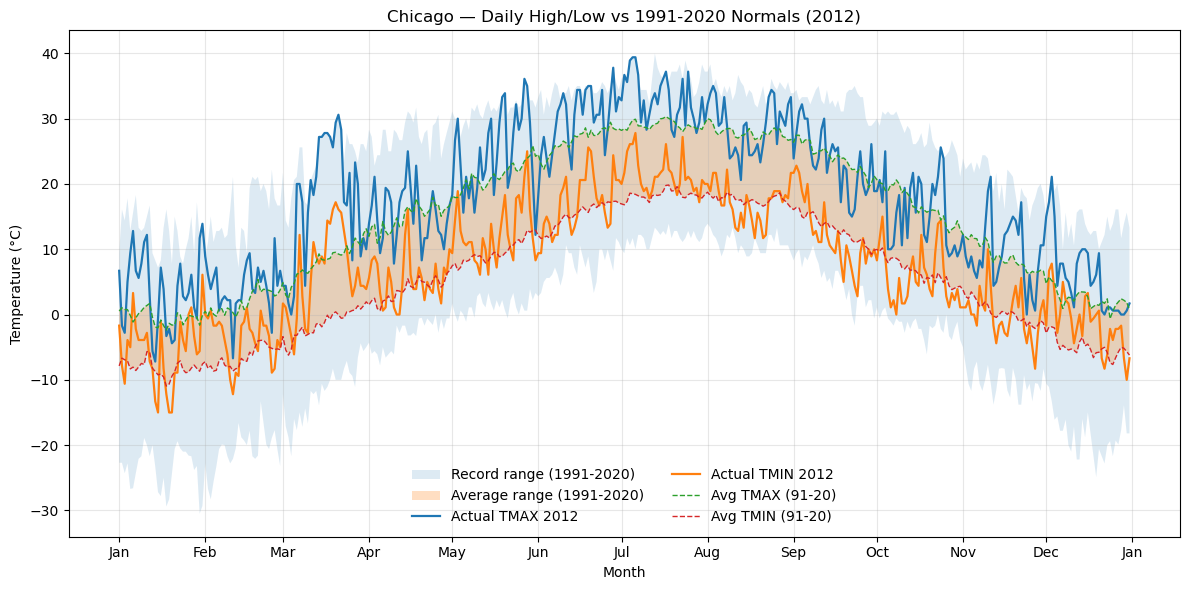

In [ ]:

# Notes:
#   - Uses NOAA GHCN-Daily data (public S3).
#   - Temperatures are converted from tenths °C to °C.
#   - Climatology period: 1991-2020 (Feb 29 excluded).

# --- Plot daily record/average vs actual high/low temps for one city & year ---


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

# GET STATION AND YEAR ===
# Station ID example: USW00094846 = Chicago O'Hare.
# YEAR is any single calendar year to plot actual highs/lows.
STATION_ID = "USW00094846" #Chicago O'Hare
YEAR = 2012

# LOAD STATION DATA FROM S3
# Read the station CSV directly from the S3 bucket via s3fs

url = f"s3://noaa-ghcn-pds/csv/by_station/{STATION_ID}.csv"
df = pd.read_csv(
        url,
        storage_options={"anon": True},
        dtype={"Q_FLAG": "object", "M_FLAG": "object"},
        parse_dates=["DATE"]
    )

# Keep only TMAX/TMIN and the 1991–2020 period

df = df[df["ELEMENT"].isin(["TMAX", "TMIN"])]
df = df[(df["DATE"].dt.year >= 1991) & (df["DATE"].dt.year <= 2020)]

# Convert units; handle GHCN missing = -9999

df["VALUE_C"] = pd.to_numeric(df["DATA_VALUE"], errors="coerce").replace(-9999, np.nan) / 10.0


# Pivot to a daily table with columns TMAX and TMIN for each DATE.
daily = df.pivot_table(index="DATE", columns="ELEMENT", values="VALUE_C")


# Create month–day key and drop Feb 29.
daily["MM-DD"] = daily.index.strftime("%m-%d")
daily = daily[daily["MM-DD"] != "02-29"]

# For each calendar day, compute record min/max and average min/max.
g = daily.groupby("MM-DD")
out = pd.DataFrame({
        "record_min_temp": g["TMIN"].min(),
        "average_min_temp": g["TMIN"].mean(),
        "average_max_temp": g["TMAX"].mean(),
        "record_max_temp": g["TMAX"].max(),
    }).sort_index()

# GET ACTUAL DAILY HIGHS/LOWS FOR THE CHOSEN YEAR (exclude Feb 29)
dyear = df[df["DATE"].dt.year == YEAR].copy()
daily_act = dyear.pivot_table(index="DATE", columns="ELEMENT", values="VALUE_C").sort_index()
daily_act["MM-DD"] = daily_act.index.strftime("%m-%d")
daily_act = daily_act[daily_act["MM-DD"] != "02-29"]
actual = daily_act.set_index("MM-DD")[["TMAX", "TMIN"]]


# Join actual year columns (TMAX, TMIN) to the calendar-day climatology table.
merged = out.join(actual, how="left")  # columns: record_min/avg_min/avg_max/record_max, TMAX, TMIN

# Build an x-axis of dates using a non-leap reference year for clean month ticks
# Use 2001 (non-leap) to create a consistent daily timeline for plotting.
xdates = pd.to_datetime("2001-" + merged.index)  # 2001 is a common non-leap year

# === 5) PLOT ===
# Create the figure and axes, then draw record/average bands and actual lines.
fig, ax = plt.subplots(figsize=(12, 6))

# Record band (envelope of all-time min..max for each calendar day, 1991–2020)
ax.fill_between(
    xdates, merged["record_min_temp"], merged["record_max_temp"],
    alpha=0.15, label="Record range (1991-2020)"
)

# Average band (avg min..avg max for each calendar day, 1991–2020)
ax.fill_between(
    xdates, merged["average_min_temp"], merged["average_max_temp"],
    alpha=0.25, label="Average range (1991-2020)"
)

# Actual year lines
# Plot actual daily high and low temperatures for the chosen year.
ax.plot(xdates, merged["TMAX"], lw=1.6, label=f"Actual TMAX {YEAR}")
ax.plot(xdates, merged["TMIN"], lw=1.6, label=f"Actual TMIN {YEAR}")

# Optional: dashed lines for the average max/min
# Overlay climatological average high/low for additional context.
ax.plot(xdates, merged["average_max_temp"], lw=1.0, ls="--", label="Avg TMAX (91-20)")
ax.plot(xdates, merged["average_min_temp"], lw=1.0, ls="--", label="Avg TMIN (91-20)")

# Styling
# Label axes, set title, format months, add grid and legend.
ax.set_xlabel("Month")
ax.set_ylabel("Temperature (°C)")
ax.set_title(f"Chicago — Daily High/Low vs 1991-2020 Normals ({YEAR})")
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b"))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, frameon=False)
fig.tight_layout()
plt.show()
